In [25]:
from IPython.display import Image
%matplotlib inline
import numpy
import scipy
import pylab
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import xml.etree.ElementTree as et
import pandas as pd
import glob
import numpy as np
import seaborn as sns

## **Oceans of 'omics**: A foray into TARA with Sourmash

### Harriet Alexander

##### DIB Lab meeting

##### April 2017



## Tara Oceans

* Global oceanic survey on the schooner Tara (~€10 million)
* A sort of reprise of GOS (J.C. Venter) 
* Generated > 35,000 samples
* Data hosted through the EMBL/EBI 
![title](Presentation/Tara-Oceans-ship.jpg)


![title](Presentation/TARAOCEANS-CARTE.jpg)


## Goal: Work with the Tara dataset and explore `sourmash` utility
* Tara dataset, not unlike the MMETSP, has some nice utility: 
the samples are well documented and were collected in a similar fashion(... once you figure out how to navigate their naming hierarchy etc.) 
* Data is released as papers are published so there is a limited set of data available right now. For now, just focusing on the 'prokaryote' size fraction meta-genome data

## Workflow 
* Gather all sample attribute information for the microbial shotgun metagenome dataset 
* Gather raw data from EBI (subsample first 1 million reads from each file) 
* Interleave reads from PE fastq reads and error trim
    * `trim-low-abund.py -M 12e9 -k 20 {}`
    * Note: abundance trimming was the rate limiting step in this process
* Run sourmash compute:
    * `sourmash compute -k 21 --dna --scaled 10000 {}`
* Run sourmash compare: 
    * `sourmash compare -k 21 {}`
* Run sourmash sbt_gather against the microbial dataset: 
    * `sourmash sourmash sbt_gather -k21 --dna microbes.sbt.json {}`

In [21]:
def load_matrix_and_labels(basefile):
    D = numpy.load(open(basefile, 'rb'))
    labeltext = [ x.strip() for x in open(basefile + '.labels.txt') ]
    return (D, labeltext)
def plot_composite_matrix(D, labeltext, show_labels=True, show_indices=True):
    if show_labels:
        show_indices=True
    D = numpy.array(D, copy=True)

    fig = pylab.figure(figsize=(11,8))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])

    # plot denderogram
    Y = sch.linkage(D, method='single') # centroid  
    
    dendrolabels = labeltext
    if not show_labels:
        dendrolabels = [ str(i) for i in range(len(labeltext)) ]
                        
    Z1 = sch.dendrogram(Y, orientation='right', labels=dendrolabels,
                        no_labels=not show_indices)
    ax1.set_xticks([])

    xstart = 0.45
    width = 0.45
    if not show_labels:
        xstart = 0.315
    scale_xstart = xstart + width + 0.01

    # plot matrix
    axmatrix = fig.add_axes([xstart,0.1, width,0.6])

    # (this reorders D by the clustering in Z1)
    idx1 = Z1['leaves']
    D = D[idx1, :]
    D = D[:, idx1]

    # show matrix
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu, vmin=0, vmax=1)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.                                                            
    axcolor = fig.add_axes([scale_xstart,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    
    # print labels, if not shown
    if not show_labels:
        for i, label in enumerate(labeltext):
            print('%d\t%s' % (i, label))

    return fig


def neighborhood(iterable):
    #get previous, current, and next part of iterator. 
    iterator = iter(iterable)
    prev_item = None
    current_item = next(iterator)  # throws StopIteration if empty.
    for next_item in iterator:
        yield (prev_item, current_item, next_item)
        prev_item = current_item
        current_item = next_item
    yield (prev_item, current_item, None)



# Results

In [20]:
tree = et.parse('sample-attributes/ERS477979.xml')

columns=[]
for elem in tree.iter():
#     print elem.tag, elem.attrib, elem.text
    if elem.tag.startswith('DB'):
        columns+=[elem.text]

    elif elem.tag.startswith('TAG'):
        columns+=[elem.text]

sampleAttributes=pd.DataFrame(columns=columns)    


for xmlfile in glob.glob('sample-attributes/*xml'):
    ersName = xmlfile.split('/')[1].split('.')[0]
    
    tree = et.parse(xmlfile)
    for prev_elem, elem, next_elem in neighborhood(tree.iter()):
        if elem.tag.startswith('DB'):
            colName = elem.text
            elem = next(tree.iter())
            val=next_elem.text
            sampleAttributes.loc[ersName,colName]=val
        elif elem.tag.startswith('TAG'):
            colName = elem.text
            elem = next(tree.iter())
            val=next_elem.text
            sampleAttributes.loc[ersName,colName]=val

for col in [ u'Size Fraction Lower Threshold', u'Size Fraction Upper Threshold', u'Latitude Start', u'Longitude Start', u'Latitude End', u'Longitude End', 
            u'Depth',u'Salinity Sensor', u'Oxygen Sensor', u'Nitrate Sensor', u'Chlorophyll Sensor',]:
    sampleAttributes[col]=pd.to_numeric(sampleAttributes[col])
    
    
sungawa=pd.read_csv('tara-analyses/Sunagawa_TableS1.csv', index_col='INSDC sample accession number(s)')
cols = ['Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
        'Marine provinces  (Longhurst 2007)', 'Environmental Feature']
sampleAttributes=sampleAttributes.merge(sungawa[cols], 
                       left_index=True, right_index=True)
sampleAttributes.columns=[u'ENA-STUDY', u'ENA-EXPERIMENT', u'ENA-RUN', u'ENA-SUBMISSION',
       u'ENA-FASTQ-FILES', u'ENA-SUBMITTED-FILES', u'Sampling Campaign',
       u'Sampling Station', u'Sampling Platform', u'Event Label',
       u'Event Date/Time Start', u'Event Date/Time End', u'Latitude Start',
       u'Longitude Start', u'Latitude End', u'Longitude End', u'Depth',
       u'Sample Collection Device', u'Protocol Label',
       u'Size Fraction Lower Threshold', u'Size Fraction Upper Threshold',
       u'Sample Status', u'Last Update Date', u'Marine Region', u'Temperature',
       u'Salinity Sensor', u'Oxygen Sensor', u'Nitrate Sensor',
       u'Chlorophyll Sensor', u'Environment (Biome)', u'Environment (Feature)',
       u'Environment (Material)', u'Environmental Package', u'Citation',
       u'Further Details', u'Project Name', u'ENA-CHECKLIST',
       u'ENA-SPOT-COUNT', u'ENA-BASE-COUNT', u'ENA-FIRST-PUBLIC',
       u'ENA-LAST-UPDATE',
       u'Ocean regions',
       u'Marine provinces', u'Environmental Feature']
sampleAttributes['ORs']=sampleAttributes['Ocean regions'].str.replace(r'\).*', '').str.replace('(', '')
sampleAttributes['EFs']=sampleAttributes['Environmental Feature'].str.replace(r'\).*', '').str.replace('(', '')

lst_col = 'ENA-RUN'
x = sampleAttributes.assign(**{lst_col:sampleAttributes[lst_col].str.split(',')})
ERA_sampleAtr=pd.DataFrame({col:np.repeat(x[col].values, x[lst_col].str.len()) for col in x.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(
            x[lst_col].values)})[x.columns.tolist()]
ERA_sampleAtr=ERA_sampleAtr.set_index('ENA-RUN')

ERA_sampleAtr.head()

,ENA-STUDY,ENA-EXPERIMENT,ENA-SUBMISSION,ENA-FASTQ-FILES,ENA-SUBMITTED-FILES,Sampling Campaign,Sampling Station,Sampling Platform,Event Label,Event Date/Time Start,...,ENA-CHECKLIST,ENA-SPOT-COUNT,ENA-BASE-COUNT,ENA-FIRST-PUBLIC,ENA-LAST-UPDATE,Ocean regions,Marine provinces,Environmental Feature,ORs,EFs
ENA-RUN,,,,,,,,,,,,,,,,,,,,,
ERR598950,ERP001736,"ERX555913,ERX556067",ERA323369,http://www.ebi.ac.uk/ena/data/warehouse/filere...,http://www.ebi.ac.uk/ena/data/warehouse/filere...,TARA_20090913Z,TARA_004,SV Tara,TARA_20090915T1800Z_004_EVENT_PUMP,2009-09-15T18:00,...,ERC000030,238146548,46805953681,2014-09-12,2015-11-04,(NAO) North Atlantic Ocean [MRGID:1912],(NAST-E) North Atlantic Subtropical Gyral Prov...,(DCM) deep chlorophyll maximum layer (ENVO:010...,NAO,DCM
ERR599095,ERP001736,"ERX555913,ERX556067",ERA323369,http://www.ebi.ac.uk/ena/data/warehouse/filere...,http://www.ebi.ac.uk/ena/data/warehouse/filere...,TARA_20090913Z,TARA_004,SV Tara,TARA_20090915T1800Z_004_EVENT_PUMP,2009-09-15T18:00,...,ERC000030,238146548,46805953681,2014-09-12,2015-11-04,(NAO) North Atlantic Ocean [MRGID:1912],(NAST-E) North Atlantic Subtropical Gyral Prov...,(DCM) deep chlorophyll maximum layer (ENVO:010...,NAO,DCM
ERR598955,ERP001736,"ERX555964,ERX556024",ERA323369,http://www.ebi.ac.uk/ena/data/warehouse/filere...,http://www.ebi.ac.uk/ena/data/warehouse/filere...,TARA_20090913Z,TARA_004,SV Tara,TARA_20090915T1130Z_004_EVENT_PUMP,2009-09-15T11:30,...,ERC000030,202168446,39822071771,2014-09-12,2015-11-04,(NAO) North Atlantic Ocean [MRGID:1912],(NAST-E) North Atlantic Subtropical Gyral Prov...,(SRF) surface water layer (ENVO:00002042),NAO,SRF
ERR599003,ERP001736,"ERX555964,ERX556024",ERA323369,http://www.ebi.ac.uk/ena/data/warehouse/filere...,http://www.ebi.ac.uk/ena/data/warehouse/filere...,TARA_20090913Z,TARA_004,SV Tara,TARA_20090915T1130Z_004_EVENT_PUMP,2009-09-15T11:30,...,ERC000030,202168446,39822071771,2014-09-12,2015-11-04,(NAO) North Atlantic Ocean [MRGID:1912],(NAST-E) North Atlantic Subtropical Gyral Prov...,(SRF) surface water layer (ENVO:00002042),NAO,SRF
ERR599073,ERP001736,"ERX555962,ERX556039",ERA323370,http://www.ebi.ac.uk/ena/data/warehouse/filere...,http://www.ebi.ac.uk/ena/data/warehouse/filere...,TARA_20091031Z,TARA_018,SV Tara,TARA_20091102T1407Z_018_EVENT_PUMP,2009-11-02T14:07,...,ERC000030,204010591,40611660735,2014-09-12,2015-11-04,(MS) Mediterranean Sea [MRGID:1905],"(MEDI) Mediterranean Sea, Black Sea Province [...",(DCM) deep chlorophyll maximum layer (ENVO:010...,MS,DCM


## Results
### Distance metrics for abundance trimmed vs. non-trimmed data

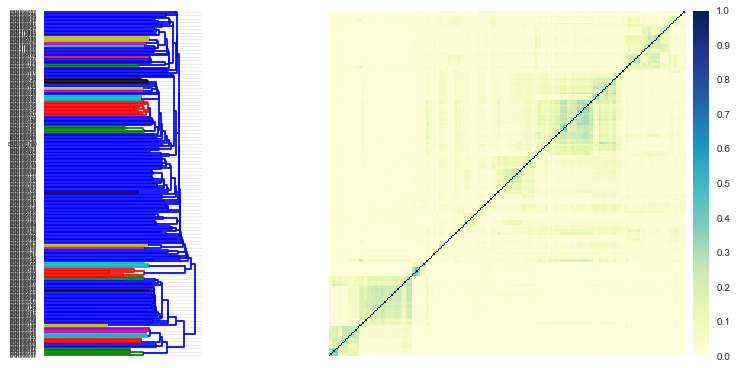

In [29]:
D_filename = 'sourmash-sigs/abundtrim.dist'

D, labeltext = load_matrix_and_labels(D_filename)
labeltext=[label.split('_')[0] for label in labeltext]
abundTrim=pd.DataFrame(data=D, index=labeltext, columns=labeltext)
for i in range(len(labeltext)):
    if i % 2:
        labeltext[i] = labeltext[i]
_ = plot_composite_matrix(D, labeltext)


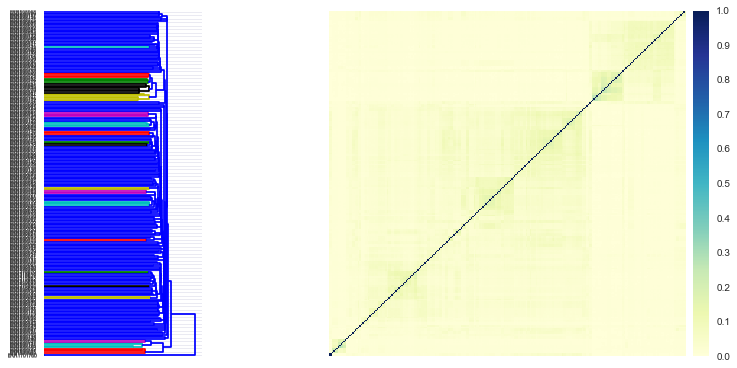

In [28]:
D_filename = 'sourmash-sigs/raw-reads.dist'

D, labeltext = load_matrix_and_labels(D_filename)
labeltext=[label.split('_')[0] for label in labeltext]
abundTrim=pd.DataFrame(data=D, index=labeltext, columns=labeltext)
for i in range(len(labeltext)):
    if i % 2:
        labeltext[i] = labeltext[i]
_ = plot_composite_matrix(D, labeltext)


## Coloring samples by oceanic region / Environmental Feature
### Sungawa et al. 2015
![title](Presentation/F1.large.jpg)


[]

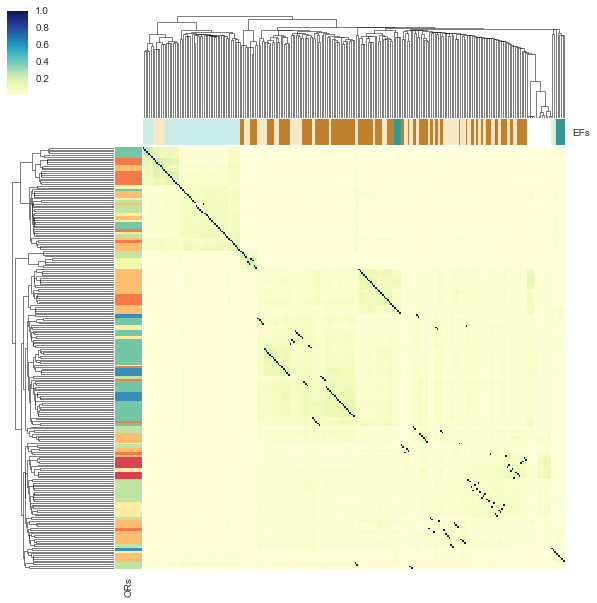

In [27]:

ERA_sampleAtr=ERA_sampleAtr[['ORs','EFs', 'Sampling Station']]
abundTrim2=abundTrim.merge(ERA_sampleAtr, left_index=True, right_index=True)


#color by region
network_pal=sns.color_palette('Spectral', len(abundTrim2.ORs.unique()))
network_lut = dict(zip(abundTrim2.ORs.unique(), network_pal))
networks = abundTrim2.ORs
network_colors = pd.Series(networks).map(network_lut)
#color by environmental factor
network_pal=sns.color_palette('BrBG', len(abundTrim2.EFs.unique()))
network_lut = dict(zip(abundTrim2.EFs.unique(), network_pal))
networks = abundTrim2.EFs
network_colors2 = pd.Series(networks).map(network_lut)
#plot cluster map
o=sns.clustermap(abundTrim2.iloc[:,:-3], row_colors=network_colors, col_colors=network_colors2,cmap="YlGnBu")
o.ax_heatmap.set_xticklabels('')
o.ax_heatmap.set_yticklabels('')

## Results
### SBT Gather results for each sample vs. microbes

In [31]:
test=pd.read_table('tara-analyses/ERP001736_taxonomy_abundances_v2.0.tsv')
splitGenus=test['#SampleID'].str.split(';', expand=True)
splitGenus.columns=['Root', 'k', 'p', 'c', 'o', 'f', 'g', 's']
splitGenus=splitGenus.T.drop('Root').T
Tara_taxonomy = splitGenus.join(test).T.drop('#SampleID').T
Tara_taxonomy.columns[Tara_taxonomy.columns.str.startswith('ERR')]

Index(['ERR164407', 'ERR164408', 'ERR164409', 'ERR315858', 'ERR315859',
       'ERR315860', 'ERR315861', 'ERR315862', 'ERR315863', 'ERR318618',
       ...
       'ERR599167', 'ERR599168', 'ERR599169', 'ERR599170', 'ERR599171',
       'ERR599172', 'ERR599173', 'ERR599174', 'ERR599175', 'ERR599176'],
      dtype='object', length=248)

In [32]:
Genus_Tara_taxonomy=Tara_taxonomy.iloc[:,5:].groupby('g').sum()
Genus_Tara_taxonomy=Genus_Tara_taxonomy.T.drop('s').T
Genus_Tara_taxonomy.loc['sum']=Genus_Tara_taxonomy.sum()
Genus_Tara_taxonomy['sum']=Genus_Tara_taxonomy.sum(axis=1)
Genus_Tara_taxonomy=Genus_Tara_taxonomy.sort('sum',ascending=False).sort('sum',axis=1, ascending=False).drop('sum').T.drop('sum').T

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [33]:
ERRList=Tara_taxonomy.columns[Tara_taxonomy.columns.str.startswith('ERR')]
import os

sbt_gather=pd.DataFrame(columns=ERRList, dtype='float')

for ERRfile in glob.glob('sourmash-sigs/abundtrim/sbt_gather/*microbes'):
    ERRname= ERRfile.split('/')[3].split('_')[0]
    if ERRname in ERRList:
        if os.stat(ERRfile).st_size > 0:
            with open(ERRfile) as f:
                next(f)
                for line in f:
                    line=line.strip().split(' ')
                    percent=float(line[0])
                    NC=line[1]
                    genus = line[2]
                    if genus in sbt_gather.index:
                        if sbt_gather.loc[genus, ERRname] > 0:
                            sbt_gather.loc[genus, ERRname] += percent
                        else:
                            sbt_gather.loc[genus, ERRname] = percent
                    else:
                        sbt_gather.loc[genus, ERRname] = percent

sbt_gather.loc['sum']=sbt_gather.sum()
sbt_gather=sbt_gather.sort('sum', axis=1, ascending=False)
sbt_gather['sum2']=sbt_gather.sum(axis=1)
sbt_gather=sbt_gather.sort('sum2', ascending=False)
sbt_gather=sbt_gather.drop('sum').T.drop('sum2').T



//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


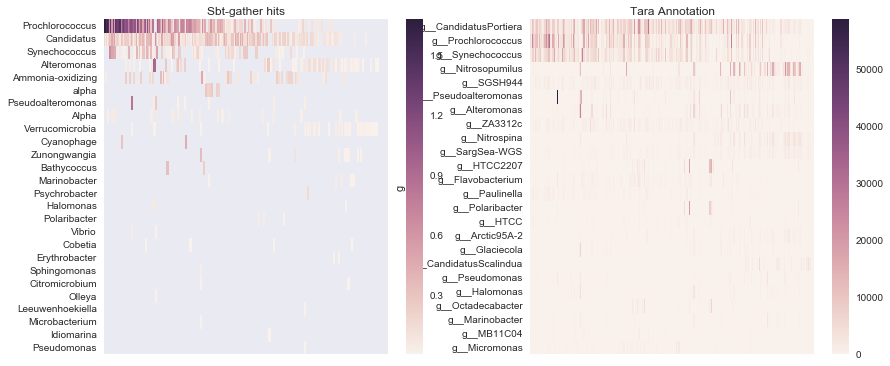

In [46]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(14,6)

hm=sns.heatmap(sbt_gather, ax=ax[0])
hm.set_xticklabels('')
hm.set_title('Sbt-gather hits')

Genus_Tara_taxonomy=Genus_Tara_taxonomy.astype('float'
hm2=sns.heatmap(Genus_Tara_taxonomy.iloc[1:25][sbt_gather.columns], ax=ax[1])
hm2.set_xticklabels('')
hm2.set_title('Tara Annotation')

## Thoughts moving forward
* I am impressed that `sbt_gather` was able to identify the top organisms from the metagenome assembly
* Clearly resolution was lower-- but that is to be expected. Some of this might be improved by looking at the signatures from the whole data file rather than just the first 1million reads. 
* Parameterization (as always...). I have a feeling that k=31 will be more appropriate? 
* Interested in trying to compare Tara data to other ocean omic datasets. 